In [1]:
from classes_v2 import * 
from ellipsoids_functions import *   

# Modele de Mori-Tanaka

In [2]:
def Mori_tanaka(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        # Création des matrices de rotations
        Rotation_Operator = Rotation_operator(n_renforts)
        B = np.zeros((3,3,3,3))
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation
            
            V3 = Comp66_to_3333(V6i)
            for j in range(n_renforts) :                 
                V3R = Rotation_tensor(V3,Rotation_Operator,j,B)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        Sh = inv(Ch)
        
        return {'C' : Ch, 'S' : Sh}

# Modele Autocoherent

In [3]:
def Self_Consistent(Cm, inclusion_behaviors):
    # Paramètres internes du modèles         
    n_renforts = 1     # paramètre non physique qui permet de forcer l'isotropie
    n_points_fixe = 10   # précise le nombre de pas de dilution (pour l'initialisation du point fixe)
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe
    seuil_divergence = 100 # Nombre d'itération au bou duquel on considère le modèle comme divergent
    ### Seulement pour le test ####
    LE = np.zeros(n_points_fixe+1)
    F = np.zeros(n_points_fixe+1)
    ################################
    Sm = Cm['S']
    Cm = Cm['C']
    Id = np.identity(6) 
    n_inclusions = len(inclusion_behaviors)

    # Création des matrices de rotations
    Rotation_Operator = Rotation_operator(n_renforts)
    B = np.zeros((3,3,3,3))

    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm

    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_points_fixe+1) :
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        convergence = 2
        n_boucles = 0
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        #print(i," pas sur ",n_points_fixe)
        while convergence>precision : 
            
            # Comptage du nombre de boucle pour l'arrêter en cas de divergence
            n_boucles += 1   
            if n_boucles >seuil_divergence : 
                raise NameError('Self-Consistent model diverge for the values prescribed from the step '+str(i))
                
                
            W = np.zeros((6,6))           # Matrice des contributions de l'inclusion dans Ch

            # Boucle sur les différentes formes d'inclusions
            for j in range(n_inclusions) : 
                Cf = inclusion_behaviors[j][0]['C']
                fi_pas = inclusion_behaviors[j][1]*i/n_points_fixe
                fi_1_renfort = fi_pas/n_renforts 
                a2,a3 = inclusion_behaviors[j][2]
                A = 1,a2,a3
                
                Esh = Eshelby_tensor(A,Eh,nuh)
                Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
                
                V6 = np.dot(Cf-Cm,Aesh)
                V3 = Comp66_to_3333(V6)

                # Ajout des contribution de chaque renfort en fonction de son orientation
                V3 = Comp66_to_3333(V6i)
                for j in range(n_renforts) :                 
                    V3R = Rotation_tensor(V3,Rotation_Operator,j,B)
                    V = Comp3333_to_66(V3R)
                    W += fi_1_renfort * V
            Ch = Cm + W

            # Actualisation du matériau homogénéisé
            Cp = Ch

            # Test de sortie
            E = Young_isotropeC(Cp)
            nu = nu_isotropeC(Cp)
            convergence = abs((E-Eh)/Eh)+abs((nu-nuh)/nuh)
            
            Eh = E
            nuh = nu           

            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
        print("f = ",fi_pas)
        print("E = ",E)
        print("nu = ",nu)
        print("******************")
        ### Seulement pour le test ###
        LE[i] = E
        F[i] = fi_pas
        ############################

    #return {'C' : Cp, 'S' : Sp}
    return LE,F

# Modèle Differentiel

In [4]:
def Differential(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch (f+df) = Ch(f) + 1/fm * Somme sur i (dfi*(Ci-Ch)*Aeshi)  avec Aeshi = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 1     # paramètre non physique qui permet de forcer lisotropie
        n_pas = 100
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.eye(6) 

        # Création des matrices de rotations
        Rotation_Operator = Rotation_operator(n_renforts)
        B = np.zeros((3,3,3,3))
        
        # Initialisation de la solution diluée : 
        Ch = Cm
        Sh = Sm        
        
        # Calculs préléminaires :
        Esh = []
        df = []
        Cf = []
        for i in range (len(inclusion_behaviors)) :
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])     
            
            Esh.append(Eshelby_tensor(Ai,Em,num))
            df.append(fi/n_pas)
            Cf.append(Cfi)
            
        # Boucle d'incrementation de la concentration
        for k in range (1,n_pas+1) :             
            dCh = np.zeros((6,6))
            fm_pas = 1
            for i in range(len(inclusion_behaviors)) :
                DCi = Cf[i]-Ch
                Aeshi = inv(Id + np.matmul(Esh[i],np.matmul(Sh,DCi)))                
                fi_pas = df[i]*k
                fm_pas -= fi_pas
                
                # Ajout des contribution de chaque renfort en fonction de son orientation     
                DCi3 = Comp66_to_3333(DCi)
                DCi3R = np.zeros((3,3,3,3))
                for j in range(n_renforts) :                 
                    DCi3R += Rotation_tensor(DCi3,Rotation_Operator,j,B)
                    DCi6 = Comp3333_to_66(DCi3R)
                    RCi = df[i]/n_renforts * DCi6
                    dCh += np.matmul(RCi,Aeshi)

            Ch = Ch + 1/fm_pas*dCh
            Sh = inv(Ch)
            
            E = Young_isotropeC(Ch)
            nu = nu_isotropeC(Ch)


        return {'C' : Ch, 'S' : Sh}
    

f= 0.0


C:\Users\karim\stage_homogeneisation\homogeneisation\ellispoids_functions.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  x = 2 * (C[0,0]+C[1,1]+C[2,2]) / (C[0,1]+C[0,2]+C[1,2]+C[1,0]+C[2,0]+C[2,1])


f= 0.1111111111111111
f= 0.2222222222222222
f= 0.3333333333333333
f= 0.4444444444444444
f= 0.5555555555555556
f= 0.6666666666666666
f= 0.7777777777777777
f= 0.8888888888888888
f= 1.0


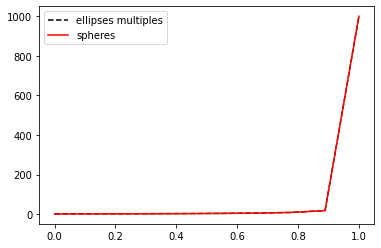

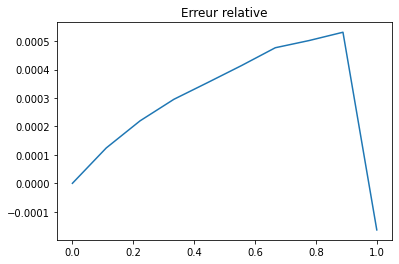

In [5]:
Ef,Em = 1000,1
nuf,num = 0.,0.
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

F = np.linspace(0,1,10)
LE2,LE3,LEr = [],[],[]
for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    
    E3 = Mori_Tanaka().compute_h_behavior(microstructure)['E']
    E2 = Young_isotropeC(Mori_tanaka(matrix_behavior,[[inclusion_behavior,f,ar]])['C'])
    
    Er = (E2-E3)/E3    
    
    LE2.append(E2)
    LE3.append(E3)
    LEr.append(Er)


plt.plot(F,LE2,'--k',label = "ellipses multiples")
plt.plot(F,LE3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F,LEr)
plt.title("Erreur relative")
plt.show()

## Comparaison avec Fortran

In [ ]:
print(LE2)
print(LE3)